Philippe Joly 27-09-24

@Author  : Linbo<linbo.me>

@Version: 1.0    25/10/2014

This is the implementation of the Zhang-Suen Thinning Algorithm for skeletonization.
source code: https://github.com/linbojin/Skeletonization-by-Zhang-Suen-Thinning-Algorithm/tree/master

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import networkx as nx

import skimage.io as io
from skimage.filters import sobel
from skimage.color import rgb2gray
from skimage.segmentation import watershed
from skimage import morphology

# Knot and Rope Skeletonization

In [2]:
i= 1
img_original =  io.imread(f'./examples/{i}_knot.png')[...,:3]      # Gray image, rgb images need pre-conversion
img_gray = rgb2gray(img_original)

## Region-Based Segmentation

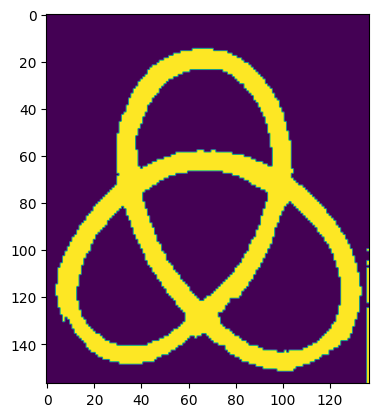

In [3]:
elevation_map = sobel(img_gray)

markers = np.zeros_like(img_gray)
markers[img_gray<30/255]=1
markers[img_gray>150/255]=2
markers = markers.astype(np.int32)

bw = watershed(elevation_map, markers)-1
plt.imshow(bw)

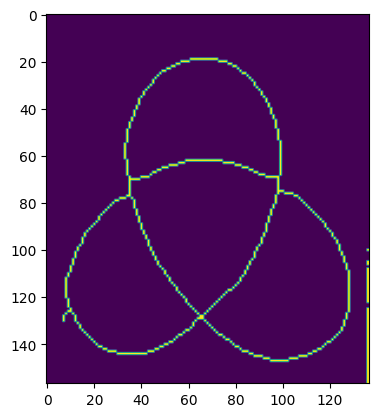

In [4]:
sk = morphology.skeletonize(bw)
plt.imshow(sk)

## Zhang's Algorithm 

In [5]:
def neighbours(x,y,image):
    "Return 8-neighbours of image point P1(x,y), in a clockwise order"
    img = image
    x_1, y_1, x1, y1 = x-1, y-1, x+1, y+1
    return [ img[x_1][y], img[x_1][y1], img[x][y1], img[x1][y1],     # P2,P3,P4,P5
                img[x1][y], img[x1][y_1], img[x][y_1], img[x_1][y_1] ]    # P6,P7,P8,P9

def transitions(neighbours):
    "No. of 0,1 patterns (transitions from 0 to 1) in the ordered sequence"
    n = neighbours + neighbours[0:1]      # P2, P3, ... , P8, P9, P2
    return sum( (n1, n2) == (0, 1) for n1, n2 in zip(n, n[1:]) )  # (P2,P3), (P3,P4), ... , (P8,P9), (P9,P2)

def zhangSuen(image):
    "the Zhang-Suen Thinning Algorithm"
    Image_Thinned = image.copy()  # deepcopy to protect the original image
    changing1 = changing2 = 1        #  the points to be removed (set as 0)
    while changing1 or changing2:   #  iterates until no further changes occur in the image
        # Step 1
        changing1 = []
        rows, columns = Image_Thinned.shape               # x for rows, y for columns
        for x in range(1, rows - 1):                     # No. of  rows
            for y in range(1, columns - 1):            # No. of columns
                P2,P3,P4,P5,P6,P7,P8,P9 = n = neighbours(x, y, Image_Thinned)
                if (Image_Thinned[x][y] == 1     and    # Condition 0: Point P1 in the object regions 
                    2 <= sum(n) <= 6   and    # Condition 1: 2<= N(P1) <= 6
                    transitions(n) == 1 and    # Condition 2: S(P1)=1  
                    P2 * P4 * P6 == 0  and    # Condition 3   
                    P4 * P6 * P8 == 0):         # Condition 4
                    changing1.append((x,y))
        for x, y in changing1: 
            Image_Thinned[x][y] = 0
        # Step 2
        changing2 = []
        for x in range(1, rows - 1):
            for y in range(1, columns - 1):
                P2,P3,P4,P5,P6,P7,P8,P9 = n = neighbours(x, y, Image_Thinned)
                if (Image_Thinned[x][y] == 1   and        # Condition 0
                    2 <= sum(n) <= 6  and       # Condition 1
                    transitions(n) == 1 and      # Condition 2
                    P2 * P4 * P8 == 0 and       # Condition 3
                    P2 * P6 * P8 == 0):            # Condition 4
                    changing2.append((x,y))    
        for x, y in changing2: 
            Image_Thinned[x][y] = 0
    return Image_Thinned

## Results

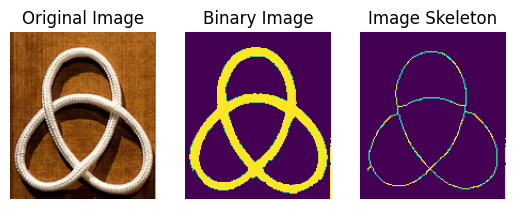

In [6]:
skeleton = zhangSuen(bw)
fig, ax = plt.subplots(1, 3)
ax1, ax2, ax3 = ax.ravel()
ax1.imshow(img_original)
ax1.set_title('Original Image')
ax1.axis('off')

ax2.imshow(bw)
ax2.set_title('Binary Image')
ax2.axis('off')

ax3.imshow(skeleton)
ax3.set_title('Image Skeleton')
ax3.axis('off')
plt.show()

# Skeleton Noise removal

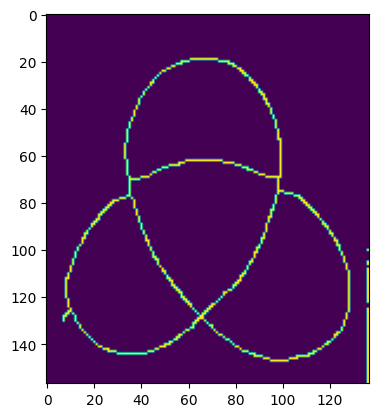

In [7]:
sk = morphology.remove_small_objects(skeleton*255, 500, connectivity=2)
plt.imshow(sk)

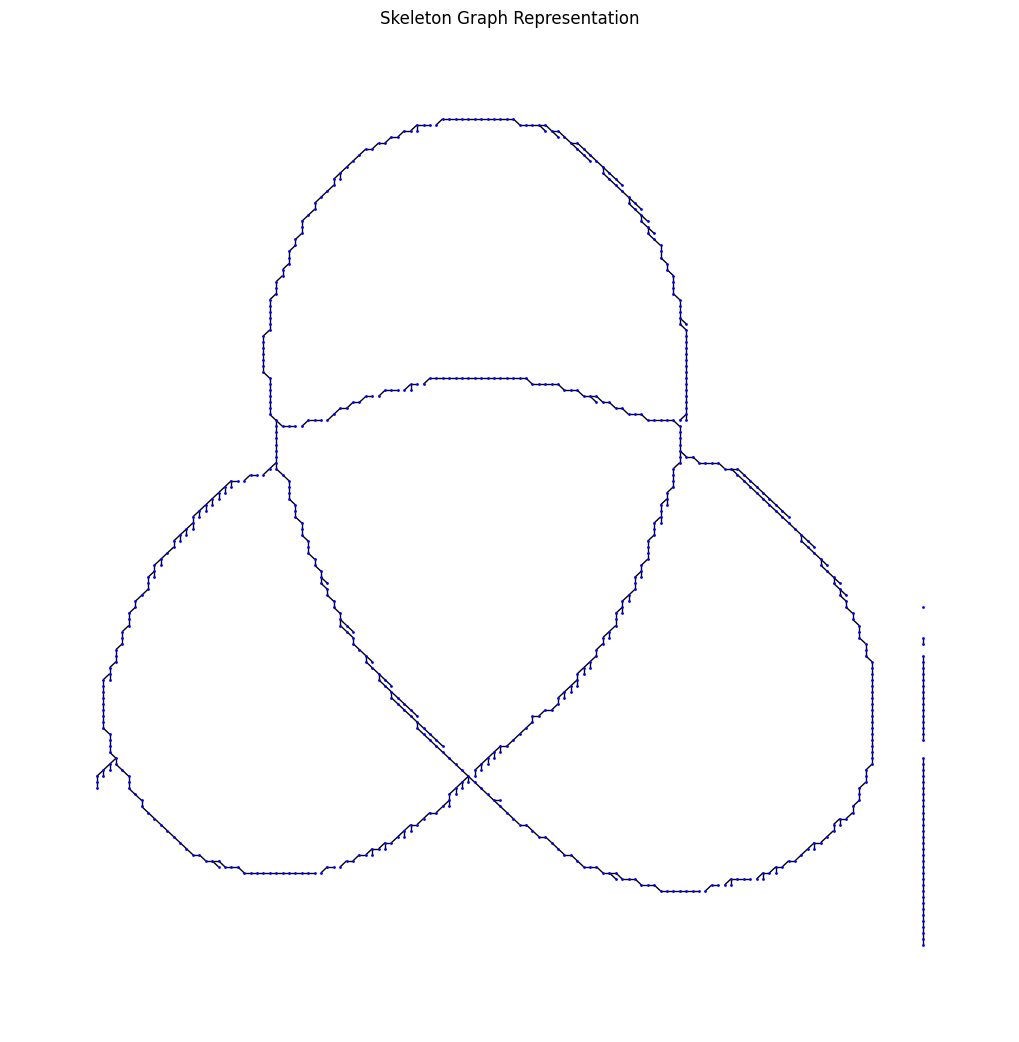

In [13]:
def sk_graph(skeleton):
    G = nx.Graph()
    rows, cols = skeleton.shape
    for r in range(rows):
        for c in range(cols):
            if skeleton[r, c]:
                G.add_node((r, c))

    # Add edges between adjacent pixels
    directions = [(-1, -1), (-1, 0), (-1, 1),
                    (0, -1),           (0, 1),
                    (1, -1),  (1, 0),  (1, 1)]

    for node in G.nodes():
        r, c = node
        for dr, dc in directions:
            nr, nc = r + dr, c + dc
            if (nr, nc) in G.nodes():
                G.add_edge((r, c), (nr, nc))
                break
    return G

G = sk_graph(skeleton)
plt.figure(figsize=(10, 10))
pos = {node: (node[1], -node[0]) for node in G.nodes()}  # Flip y-axis for correct orientation
nx.draw(G, pos, node_size=1, node_color='blue', with_labels=False)
plt.title("Skeleton Graph Representation")
plt.axis('off')
plt.show()
    

In [9]:
def prune_graph(G, min_branch_length=10):
    while True:
        dead_ends = [node for node in G.nodes() if G.degree(node) == 1]
        if not dead_ends:
            break
        for dead_end in dead_ends:
            branch = [dead_end]
            current = dead_end
            while G.degree(current) == 2:
                neighbors = list(G.neighbors(current))
                next_node = neighbors[0] if neighbors[0] != branch[-1] else neighbors[1]
                branch.append(next_node)
                current = next_node
            if len(branch) < min_branch_length:
                G.remove_nodes_from(branch[:-1])

def clean_graph(G):
    # Find the largest connected component
    largest_cc = max(nx.connected_components(G), key=len)
    G = G.subgraph(largest_cc).copy()
    
    # Prune small branches
    prune_graph(G)
    
    return G

In [10]:
# Clean the graph
# G_clean = clean_graph(G)

# # Draw the cleaned graph
# plt.figure(figsize=(10, 10))
# pos = {node: (node[1], -node[0]) for node in G_clean.nodes()}
# nx.draw(G_clean, pos, node_size=10, node_color='blue', with_labels=False, width=2)
# plt.title("Cleaned Skeleton Graph Representation")
# plt.axis('off')
# plt.tight_layout()
# plt.show()

In [11]:
def simplify_to_intersections(G):
    # Identify intersection nodes (degree > 2) and endpoints (degree == 1)
    intersection_nodes = [node for node in G.nodes() if G.degree(node) != 2]
    print(1)
    # Create a new graph with intersection nodes
    G_simple = nx.Graph()
    G_simple.add_nodes_from(intersection_nodes)
    print(2)
    # For each pair of intersection nodes, find the path between them
    for i, start_node in enumerate(intersection_nodes):
        for end_node in intersection_nodes[i+1:]:
            paths = list(nx.all_simple_paths(G, start_node, end_node))
            print(3)
            if paths:
                # Get the shortest path
                shortest_path = min(paths, key=len)
                # Add an edge to the simplified graph if it doesn't pass through other intersection nodes
                if all(node not in intersection_nodes for node in shortest_path[1:-1]):
                    G_simple.add_edge(start_node, end_node, weight=len(shortest_path)-1)
    
    return G_simple

In [12]:
G_simple = simplify_to_intersections(G)
plt.figure(figsize=(10, 10))
pos = {node: (node[1], -node[0]) for node in G_simple.nodes()}
nx.draw(G_simple, pos, node_size=50, node_color='red', with_labels=False, width=2)

# Add edge labels (weights)
edge_labels = nx.get_edge_attributes(G_simple, 'weight')
nx.draw_networkx_edge_labels(G_simple, pos, edge_labels=edge_labels)

plt.title("Simplified Skeleton Graph with Intersection Nodes")
plt.axis('off')
plt.tight_layout()
plt.show()

1
2


KeyboardInterrupt: 